### IMPORTS

In [1]:
from Inference.VariationalAE import MeanFieldVariationalAE
from Inference.Variational import MeanFieldVariationalDistribution

In [2]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses
from Tools.NNtools import *

In [3]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
def flip_parameters_to_tensors(module):
    attr = []
    while bool(module._parameters):
        attr.append( module._parameters.popitem() )
    setattr(module, 'registered_parameters_name', [])

    for i in attr:
        setattr(module, i[0], torch.zeros(i[1].shape,requires_grad=True))
        module.registered_parameters_name.append(i[0])

    module_name = [k for k,v in module._modules.items()]

    for name in module_name:
        flip_parameters_to_tensors(module._modules[name])

In [5]:
def set_all_parameters(module, theta):
    count = 0  

    for name in module.registered_parameters_name:
        a = count
        b = a + getattr(module, name).numel()
        t = torch.reshape(theta[0,a:b], getattr(module, name).shape)
        setattr(module, name, t)

        count += getattr(module, name).numel()

    module_name = [k for k,v in module._modules.items()]
    for name in module_name:
        count += set_all_parameters(module._modules[name], theta)
    return count

# Load data #

In [6]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [7]:
# load data and make it in proper shape
data_val = torch.load('data/foong_data_validation.pt')
x_data_val = data_val[0].to(device)
y_data_val = data_val[1].to(device)
y_data_val = y_data_val.unsqueeze(-1)

# Model principal

In [8]:
model = nn.Sequential( nn.Linear(1,20),
                       nn.Tanh(),               
                       nn.Linear(20,1),
                     ).to(device)
for params in model.parameters():
    params.requires_grad = False

In [9]:
param_count = get_param(model).shape[0]
param_count

61

In [10]:
flip_parameters_to_tensors(model)

# Calcul du posterior sur les paramètres principaux #

In [11]:
#Prior
sigma_prior=1.0
prior = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(param_count),sigma_prior*torch.eye(param_count))

def logprior(theta):
    return prior.log_prob(theta)

In [12]:
def log_norm(y,y_,std):
    point_estimate= torch.distributions.normal.Normal(y_, std)
    return point_estimate.log_prob(y)

In [13]:
# likelihood of the parameters
sigma_like=.1 

def loglikelihood(theta, sigma=sigma_like):
    set_all_parameters(model, theta)
    y_pred = model(x_data)
    L = log_norm(y_pred, y_data, torch.tensor([sigma],device=device))
    return torch.sum(L).unsqueeze(-1)


In [14]:
#log posterior
def logposterior(theta, sigma=sigma_like):
    return logprior(theta) + loglikelihood(theta,sigma=sigma_like)


# Modèle génératif: Hypernet autoencodeur

In [15]:
#choisir la dimension pour les paramètres latents
# lat_dim=5 donne des résultats intéressants!
lat_dim=61

In [16]:
# initialise 
# – (encodeur) une gaussienne diagonale N(0,sigma*I): mfvar ("dummy" prior sur les variables latentes)
# – (decodeur) un NN avec 1 layer param_count neurones, activtion nn.Tanh()/nn.ReLU(): decoder
# forward(n): échantilloner theta=mfvar.decoder(mfvar.sample(n))
sigma_p=1.
VAE = MeanFieldVariationalAE(lat_dim,lat_dim,param_count,nn.Tanh(),sigma=sigma_p)
print('nb de paramètres VAE:'+str(get_param(VAE).shape[0]))
VAE


nb de paramètres VAE:7686


MeanFieldVariationalAE(
  (mfvar): MeanFieldVariationalDistribution()
  (layerIn): Linear(in_features=61, out_features=61, bias=True)
  (layerOut): Linear(in_features=61, out_features=61, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=61, out_features=61, bias=True)
    (1): Tanh()
    (2): Linear(in_features=61, out_features=61, bias=True)
  )
)

In [26]:
#prior sur les paramètres lambda du decodeur

#poids d'entrée avant activation
def prior_hyperWeightsIn(w):
    return torch.nn.init.normal_(w,mean=0., std=3.)

#poids de sortie
def prior_hyperWeightsOut(w):
    return torch.nn.init.normal_(w,mean=0., std=.1)



In [27]:
#initialise les paramètres lambda du decoder, couche par couche
def init_weightsIn(m):
    if type(m) == nn.Linear:
        prior_hyperWeightsIn(m.weight)
        m.bias.data.fill_(0.00)
def init_weightsOut(m):
    if type(m) == nn.Linear:
        prior_hyperWeightsOut(m.weight)
        m.bias.data.fill_(0.00)
        
VAE.layerIn.apply(init_weightsIn)
VAE.layerOut.apply(init_weightsOut)

Linear(in_features=61, out_features=61, bias=True)

# Visualisation de l'initialisation #

<IPython.core.display.Javascript object>


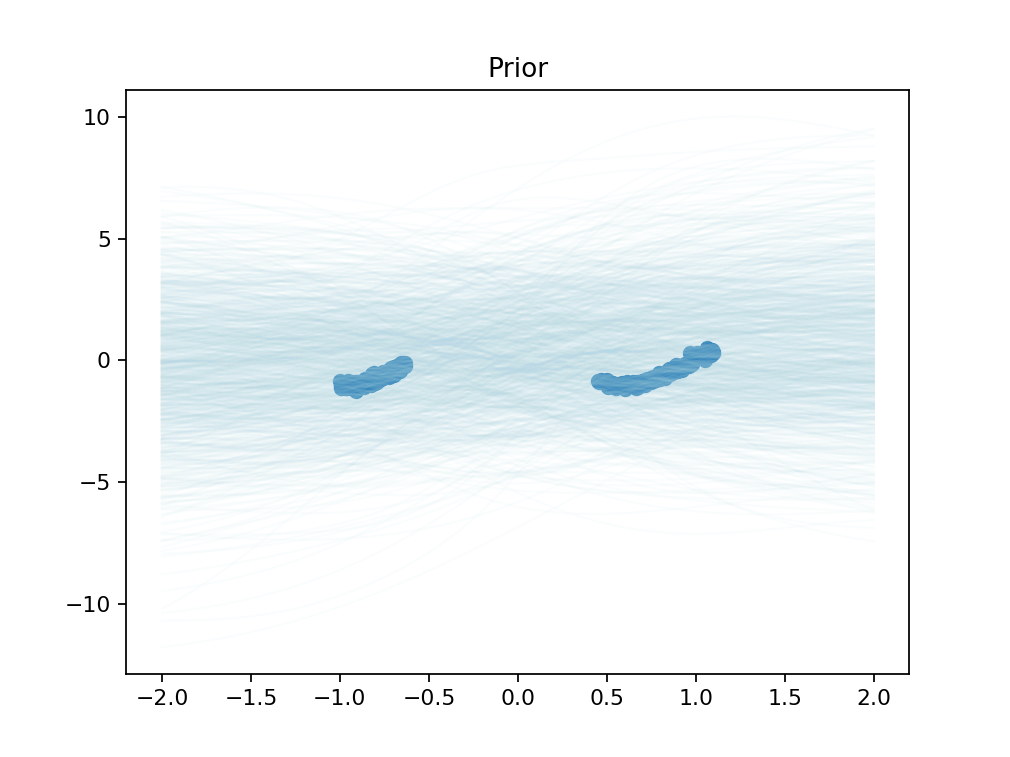

In [28]:
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib notebook
import math

x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
#fig.set_size_inches(10, 10)
plt.title('Prior')


plt.scatter(x_data.cpu(), y_data.cpu())
for i in range(1000):
    theta = VAE()
    set_all_parameters(model, theta)
    y_test = model(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')


# KL-divergence #

$$D_\text{KL}\left(\mathcal{N}\left((\mu_1, \ldots, \mu_k)^\mathsf{T}, \operatorname{diag} (\sigma_1^2, \ldots, \sigma_k^2)\right) \parallel \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)\right) = {1 \over 2} \sum_{i=1}^k (\sigma_i^2 + \mu_i^2 - \ln(\sigma_i^2) - 1).$$

$$D_\text{KL}\left(\mathcal{N}\left((\mu_1, \ldots, \mu_k)^\mathsf{T}, \operatorname{diag} (\sigma_1^2, \ldots, \sigma_k^2)\right) \parallel \mathcal{N}\left(\mathbf{0}, \sigma^2\mathbf{I}\right)\right) = {1 \over 2} \sum_{i=1}^k \Big(\frac{\sigma_i^2}{\sigma^2} + \frac{\mu_i^2}{\sigma^2} +\ln(\sigma^2)- \ln(\sigma_i^2) - 1\Big).$$

In [29]:
# KL-divergence entre une normale diagonale N(mu,diag(sigma)) et N(0,I)
def KLDivGauss(mu,sigma):
    Div=sigma+torch.pow(mu,2)-sigma.log()-1
    return 0.5*Div.sum().squeeze()

In [30]:
# KL-divergence entre une normale diagonale N(mu,diag(sigma)) et N(0,I)
def KLDivGauss_(mu,sigma,sigma_p):
    Div_=torch.mul(sigma,1/sigma_p)+torch.mul(torch.pow(mu,2),1/sigma_p)-sigma.log()-1+torch.log(torch.Tensor([sigma_p]))
    return 0.5*Div_.sum().squeeze()

In [31]:
KLDivGauss_(VAE.mfvar.mu.detach(),VAE.mfvar.sigma.detach(),sigma_p)

tensor(0.)

# Training #

Le posterior $P(\theta)$ sur les paramètres $\theta$ du modèle principal est non normalisé. C'est l'input de la méthode VAE.  L'entraînement de la distribution VAE vise à optimiser les valeurs des paramètres du VAE afin d'approcher au mieux la distribution non normalisée $P(\theta)$. Nous pouvons seulement échantilloner la distribution VAE, c'est la fonction forward de VAE: on échantillonne z selon VAE.mfvar.sample() puis on applique le decoder theta=VAE.decoder(z). La fonction de densité du VAE n'est pas disponible.

Notons le decodeur $g_{\lambda}:\mathcal{Z}\to \Theta$ pour simplifier la notation et mettre en évidence les paramètres qui le caracérise.

On définit pour tout $\lambda$ une distribution de probabilité sur les variables latentes par:
$$
P_\lambda(z)=\frac{P(z)P(g_{\lambda}(z))}{E_\lambda}.
$$
où $P(z)\sim N(0,I)$ est un "dummy" prior sur les variables latentes et la constante de normalisation est donnée par:
$$
E_\lambda=\int P(g_\lambda(z))P(z)dz.
$$

Si $Q(z)$ est une distribution quelconque sur $z$, alors:
$$
D_\text{KL}(Q(z) \mathbin{\Vert} P_\lambda(z) )=D_\text{KL}(Q(z)\mathbin{\Vert} P(z)) - E_{Q(z)}[\log P(g_\lambda(z)]+ \log E_\lambda.
$$
Donc pour tout $\lambda$:
$$
\log E_\lambda\geq \log E_\lambda-D_\text{KL}(Q(z) \mathbin{\Vert} P_\lambda(z))= -D_\text{KL}(Q(z)\mathbin{\Vert} P(z)) + E_{Q(z)}[\log P(g_\lambda(z)]=\text{ELBO}(Q,\lambda)
$$

Le but est alors de trouver une distribution $Q$ qui maximise le terme de droite. Cet objectif maximise la différence entre la log-evidence $\log E_\lambda$ et la divergence entre $Q(z)$ et la distribution $P_\lambda(z)$. 

On se restricte alors aux distributionx normales diagonales $Q(z|\mu,\sigma)\sim N(z; \mu, \text{diag}(\sigma))$. On se propose de minimiser la fonction:
$$
-\text{ELBO}(\mu,\sigma,\lambda)=D_\text{KL}(Q(z|\mu,\sigma)\mathbin{\Vert} P(z))- E_{Q(z)}[\log P(g_\lambda(z)]
$$

Si $D_\text{KL}(Q(z|\mu,\sigma) \mathbin{\Vert} P(z))$ peut être calculée en dollars et ne dépend pas de $\lambda$, le terme $E_{Q(z)}[\log P_\lambda(\text{data}|z)]$ est estimé en échantillonant des $z_i$ puis en faisant la moyenne des $\log P_\lambda(z_i)$.

Cas unidimensionnel: $P(\theta)$ distribution sur $\mathbb{R}$. Nous avons $Z$ variable aléatoire de loi normale $N(0,1)$ et notons $F(z)$ sa CDF, P(z) sa fonction de densité. Montrons qu'il existe $g:\mathbb{R}\to\mathbb{R}$ telle que $\theta=g(Z)$ est distribuée $P(\theta)$. La variable aléatoire $F(Z)$ est de loi uniforme sur $[0,1]$. En effet, en supposant que $F(z)=P(Z\leq z)$ est strictement croissante et inversible, on a $P(a\leq F(Z)\leq b)=P(F^{-1}(a)\leq Z \leq F^{-1}(b))=P(Z\leq F^{-1}(b))-P(Z\leq F^{-1}(a))=b-a$. Supposons maintenant que $P(\theta)$ admet une CDF $G(z)$ inversible et posons $g(Z)=G^{-1}(F(Z))$. Alors $g(z)$ est distribuée $P(\theta)$ comme désiré, puisque 
$$
P(g(Z)\leq \theta)=P(G^{-1}(F(Z))\leq \theta)=P(F(Z)\leq G(\theta))=G(\theta).
$$



In [32]:


n_samples_VAR = 200

In [33]:
VAE_optimizer = torch.optim.Adam(VAE.parameters(), lr=.01)
VAE_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(VAE_optimizer, patience=50, factor=0.5)


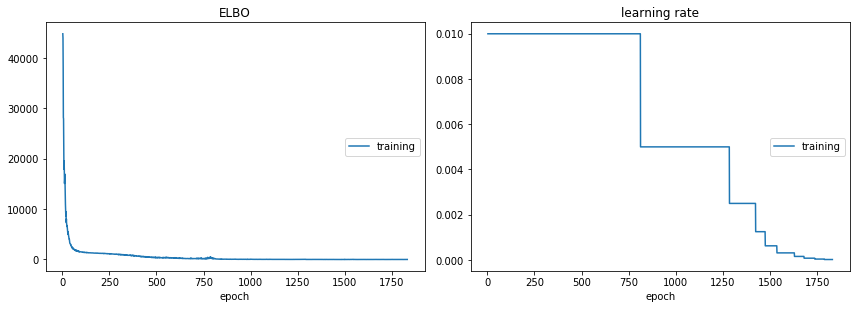

ELBO:
training   (min:  -72.480, max: 76557.422, cur:  -61.567)

learning rate:
training   (min:    0.000, max:    0.010, cur:    0.000)


In [34]:
%matplotlib inline

liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    VAE_optimizer.zero_grad()

    learning_rate = VAE_optimizer.param_groups[0]['lr']
    
    Div = KLDivGauss_(VAE.mfvar.mu,VAE.mfvar.sigma,sigma_p)
#    Div = KLDivGauss(VAE.mfvar.mu,VAE.mfvar.sigma)
    
    LL=torch.Tensor(n_samples_VAR)

    for i in range(n_samples_VAR):
        theta = VAE()
#        LL[i]=loglikelihood(z)
        LL[i]=logposterior(theta)
    L = Div - LL.mean()

    L.backward()
    

    

    VAE_scheduler.step(L.detach().clone().cpu().numpy())

    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    #logs['memory'] = torch.cuda.memory_allocated(device=device)
    #logs['predictive likelihood'] = LL.detach().clone().cpu().numpy()
    liveloss.update(logs)

    if t % 10 == 0:
        liveloss.draw()

    #if t %2 == 0:
    VAE_optimizer.step()

    if learning_rate < 0.00001:
        break

# Résultats #

In [35]:
(VAE.mfvar.mu,VAE.mfvar.sigma)

(Parameter containing:
 tensor([ 0.6874, -0.0653, -0.3318,  0.1000,  0.0678, -0.0843,  0.1713,  0.1180,
         -0.2683, -0.0150,  0.0346, -0.7770,  0.1029, -0.2033,  0.6248,  0.2186,
         -0.2043, -0.4283, -0.2827, -0.0737, -0.0012,  0.0985, -0.6800,  0.0288,
         -0.7041,  0.3314, -0.2123, -0.0865, -0.0420,  0.6320, -0.3497,  0.0166,
         -0.0162, -0.2348,  0.4290, -0.3723, -0.2181, -0.2224, -0.2261,  0.0391,
         -0.2263,  0.1732,  0.0193, -0.4294, -0.5039, -0.6305,  0.2993,  0.4347,
          0.1635,  0.2323, -0.0235,  0.3785, -0.6879,  0.5702, -0.5897,  0.0296,
          0.1736,  0.3802, -0.9443,  0.1071, -0.1476], requires_grad=True),
 tensor([0.9087, 1.0252, 0.8855, 1.0693, 0.9387, 1.0128, 0.9609, 0.9330, 1.0502,
         1.0140, 0.9790, 0.9766, 0.9645, 0.9611, 0.8661, 0.9353, 0.9379, 0.9385,
         0.9825, 0.9696, 0.9222, 0.9876, 0.8613, 1.0610, 0.8884, 0.9744, 1.0056,
         0.9620, 0.9386, 0.8860, 0.8748, 0.9910, 1.0494, 0.9128, 0.9272, 1.0104,
         0

In [36]:
for layer in VAE.decoder.modules():
    if isinstance(layer, nn.Linear):
        print(layer.weight)
        print(layer.bias)

Parameter containing:
tensor([[-0.4024, -3.6907,  0.5758,  ..., -0.3782, -3.5293, -0.7526],
        [ 0.1016, -8.0763, -3.8146,  ...,  6.3264,  0.7194, -0.4151],
        [-0.4031,  3.0310, -0.9975,  ...,  2.8896, -3.3600,  2.7613],
        ...,
        [ 0.2916, -1.7718, -0.6820,  ...,  2.6254,  0.1978,  0.8305],
        [-5.8217,  4.4972, -1.8156,  ...,  4.1159, -0.3141, -4.2796],
        [-2.6714,  6.2886, -5.3908,  ...,  3.2909,  4.0385, -5.5783]],
       requires_grad=True)
Parameter containing:
tensor([ 0.5061,  0.0426, -0.2764,  0.1700,  0.3311,  0.4406,  0.0065, -0.4035,
        -0.0087, -0.1166, -0.4103,  0.1733, -0.1167,  0.2406, -0.4026,  0.1662,
         0.0307,  0.0628,  0.0538, -0.2322,  0.0188,  0.0387,  0.0915, -0.4304,
        -0.0852, -0.2349,  0.2030,  0.5705,  0.1433,  0.3018, -0.2022, -0.1828,
        -0.2055, -0.0059,  0.3397, -0.1641,  0.2138, -0.0966, -0.1201, -0.0881,
        -0.1219, -0.3475, -0.1009,  0.0536, -0.1030,  0.0450, -0.0079, -0.0114,
        -0.4489

<IPython.core.display.Javascript object>


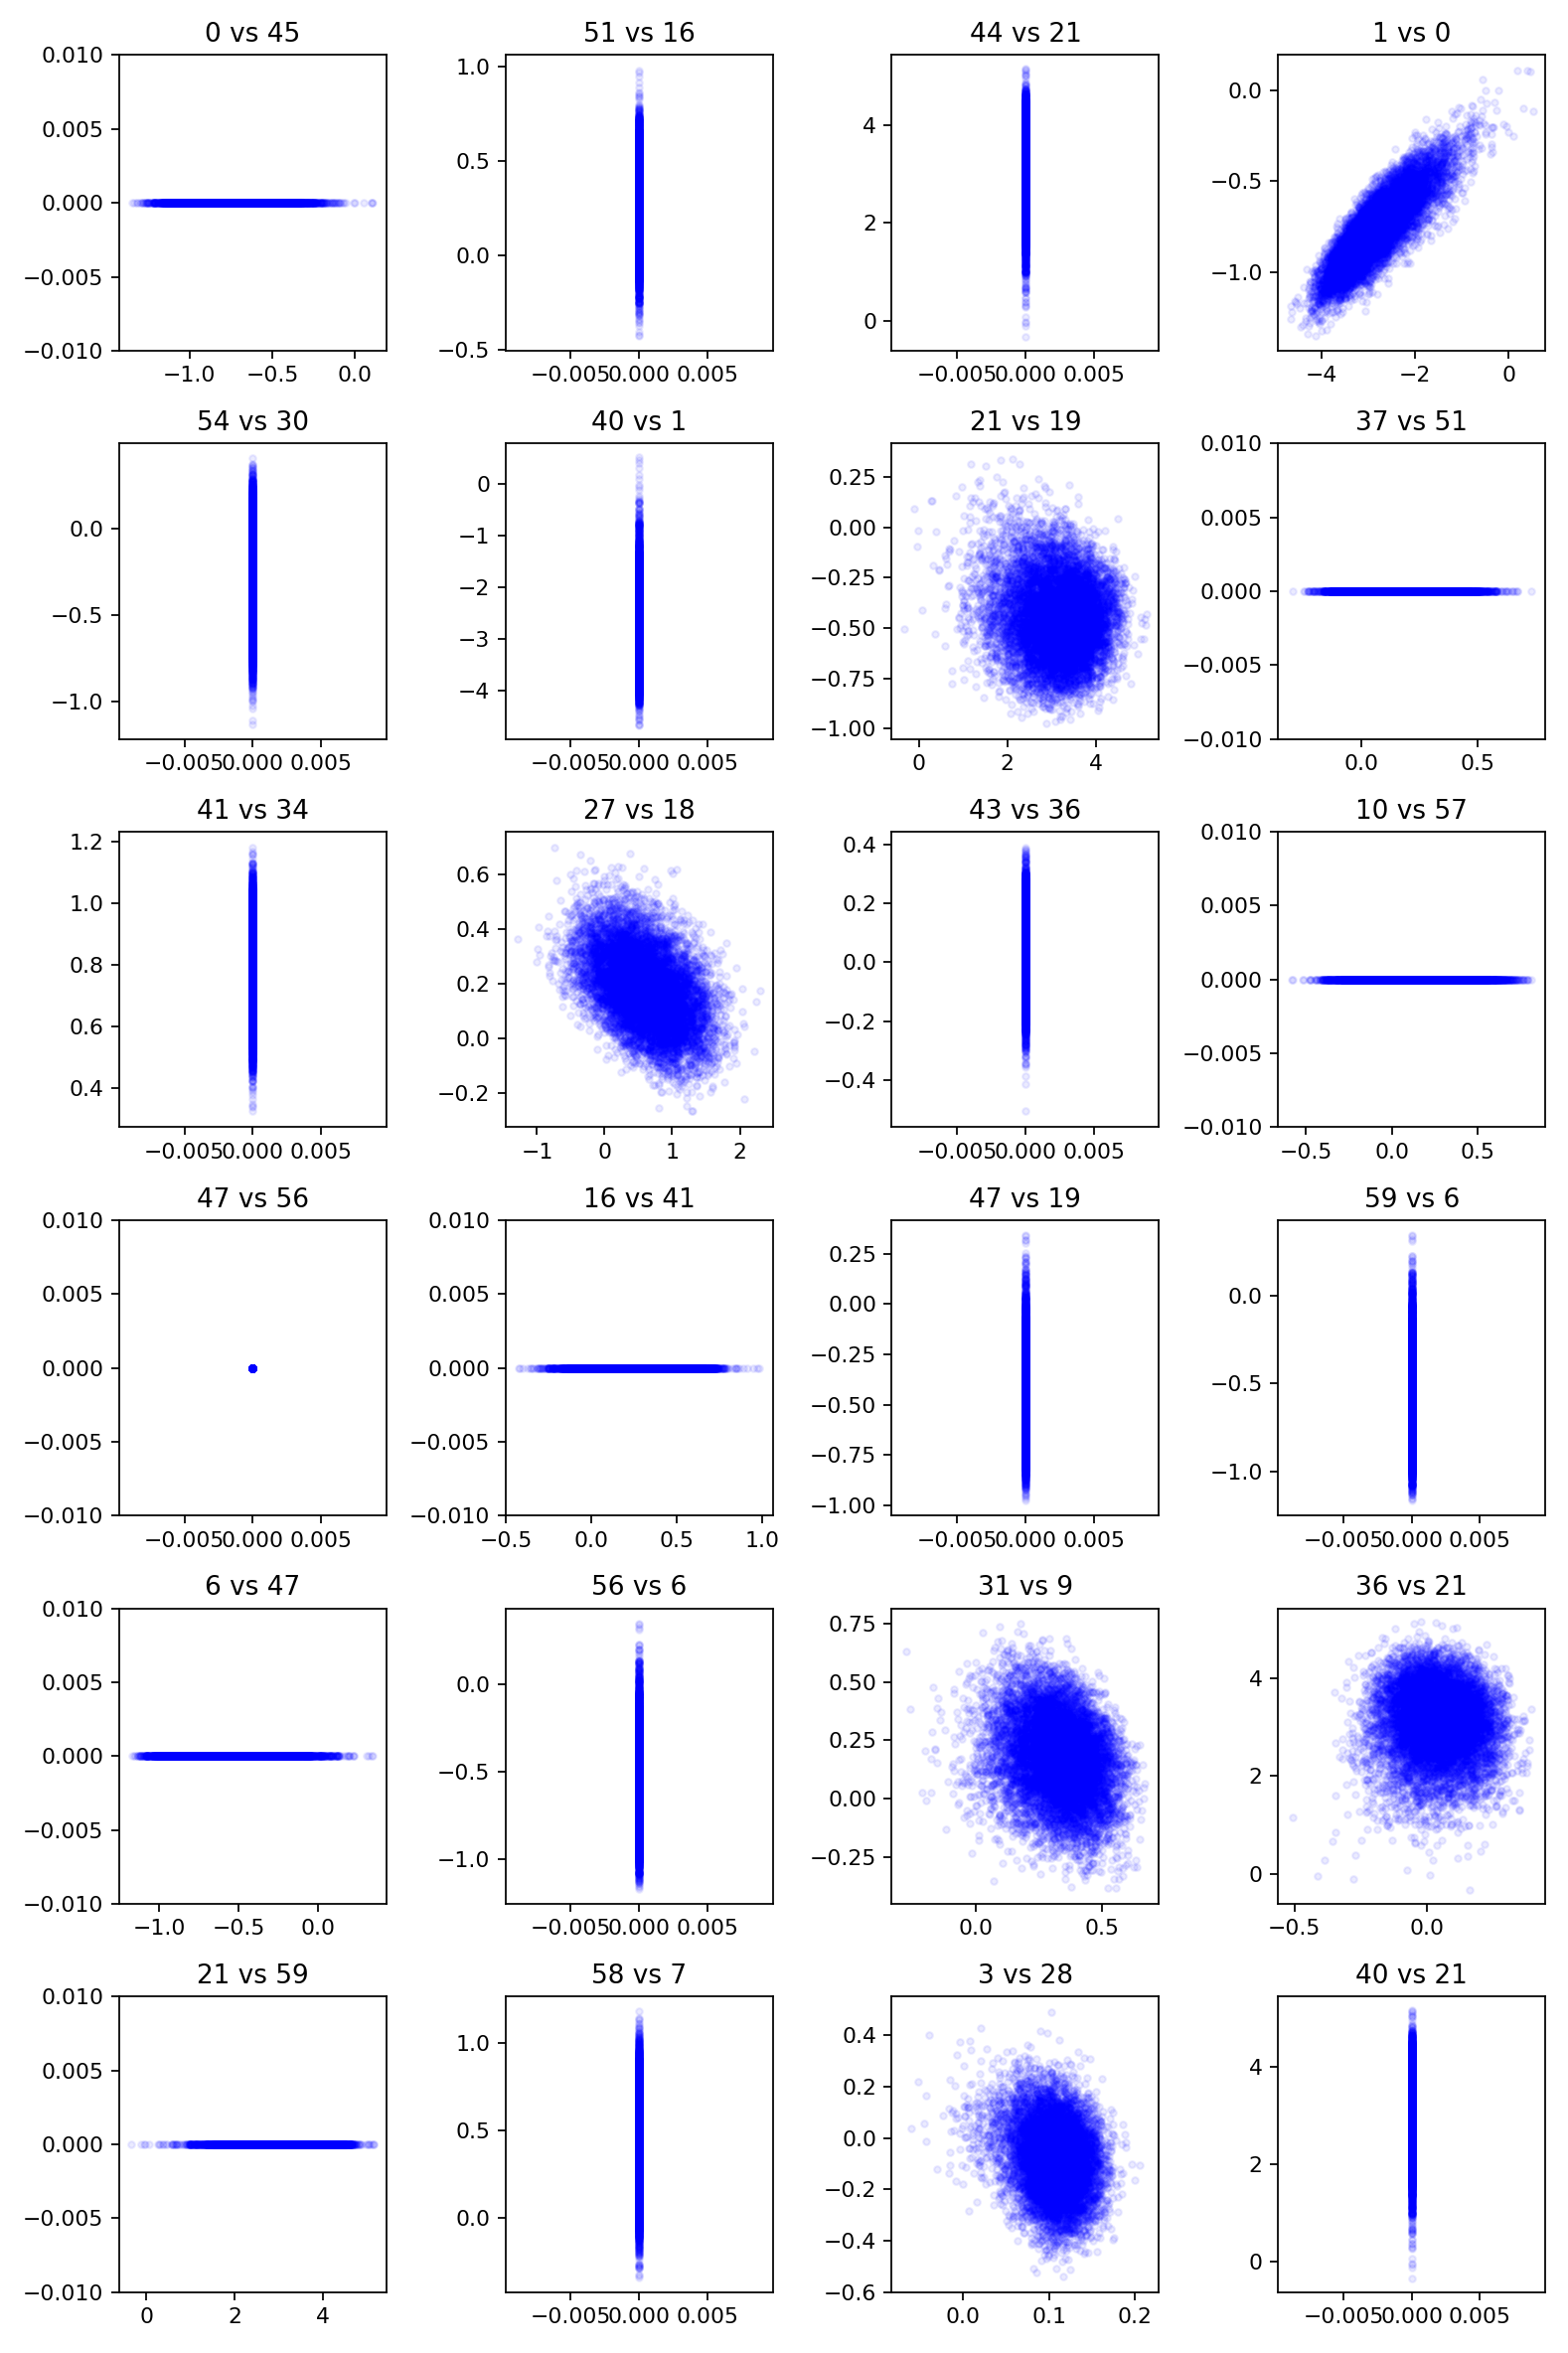

In [42]:
# aperçu de la distibution apprise sur les paramètres du modèle primaire.
# sampling of VAE 10 000 times and plotting a few 2D projections of the sampled parameters

import matplotlib.pyplot as plt
%matplotlib notebook

L = VAE(10000).detach().numpy()


fig, axs = plt.subplots(6, 4,figsize=(10,15))
for k in range(6):
    for l in range(4):
        i=np.random.choice(a=np.arange(param_count), size=2,replace=False)
        axs[k, l].scatter(L[:,i[0]],L[:,i[1]],marker='.',alpha=0.08,color='blue')
        axs[k, l].set(title=str(i[0])+' vs '+str(i[1]))
fig.tight_layout()

## Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution ##


<IPython.core.display.Javascript object>


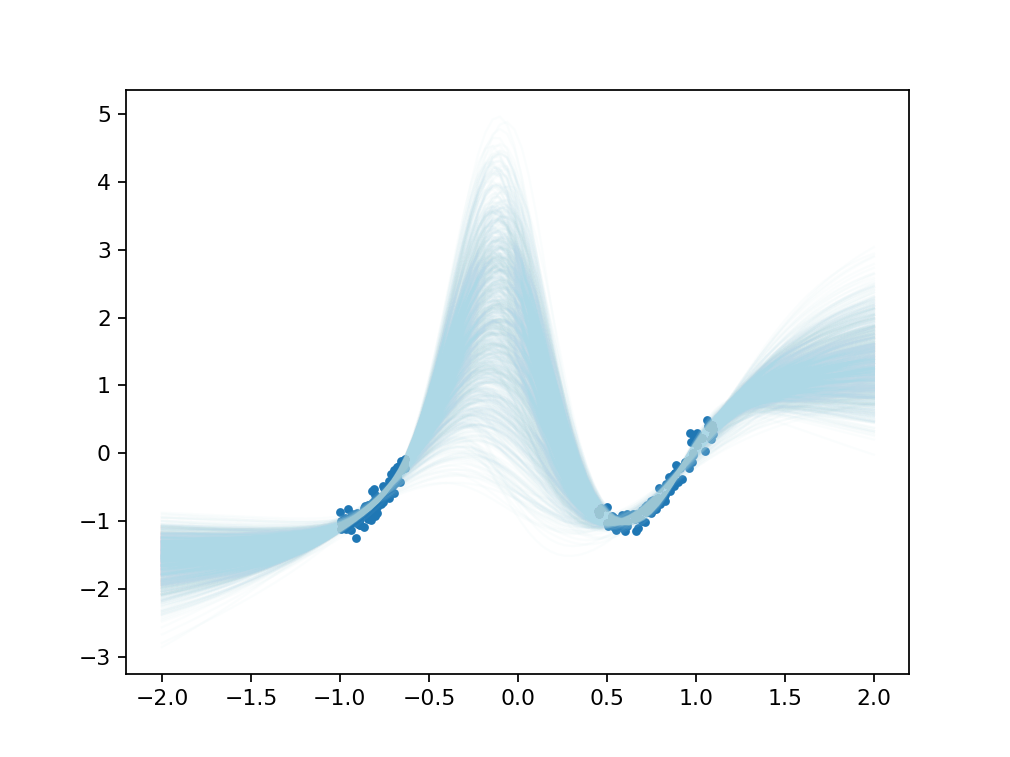

In [41]:
import matplotlib.pyplot as plt
%matplotlib notebook

x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
#fig.set_size_inches(10, 10)
plt.scatter(x_data.cpu(), y_data.cpu(),marker='.')
for i in range(1000):
    theta=VAE()
    set_all_parameters(model, theta)
    y_test = model(x_test)    
#    plt.axis('scaled')
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')



<IPython.core.display.Javascript object>


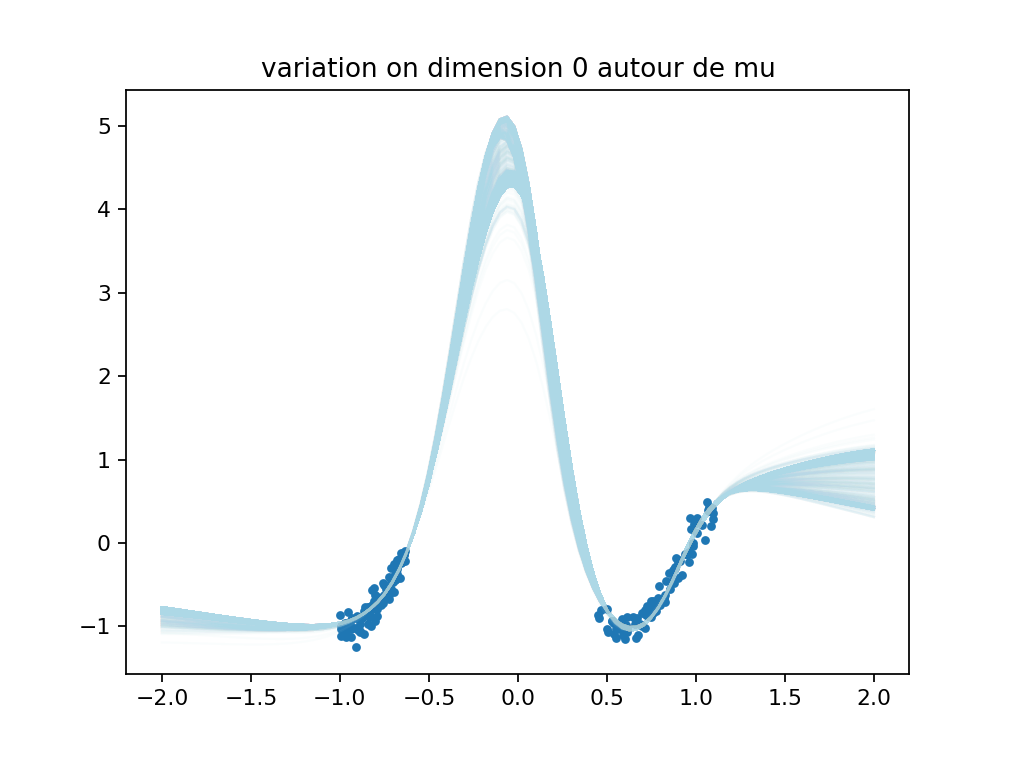

Text(0.5, 1.0, 'variation on dimension 0 autour de mu')

In [40]:
import matplotlib.pyplot as plt
%matplotlib notebook

x_test = torch.linspace(-2.,2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
#fig.set_size_inches(10, 10)
plt.scatter(x_data.cpu(), y_data.cpu(),marker='.')
j=0
for i in range(1000):
    z=torch.Tensor(1,lat_dim)
    for k in range(lat_dim):
        if k==j:
            z[0,k]=VAE.mfvar.sample().detach().squeeze()[k]
        else:
            z[0,k]=VAE.mfvar.mu[k]
    theta=VAE.decoder(z)
    set_all_parameters(model, theta)
    y_test = model(x_test)    
#    plt.axis('scaled')
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')
plt.title('variation on dimension '+str(j)+' autour de mu')


# Calcul de l'évidence #

In [ ]:
n_samples=10000

prior=torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(lat_dim), torch.eye(lat_dim))
E=torch.Tensor(n_samples)

for i in range(n_samples):
    z = prior.sample().unsqueeze(0)
    E[i]=logposterior(z)

evidence=E.logsumexp(0)-torch.log(torch.Tensor([n_samples]))

print('Log-évidence: '+str(evidence.squeeze().detach().numpy()))

In [ ]:
# estimation de l'évidence en utilisant la distribution apprise VAE.mfvar
E=torch.Tensor(n_samples)

for i in range(n_samples):
    z = VAE.mfvar.sample() 
    E[i]=logposterior(z)


print('Log-évidence estimée: '+str((E.logsumexp(0)-torch.log(torch.Tensor([n_samples]))).squeeze().detach().numpy())) 

In [ ]:
Div = KLDivGauss(VAE.mfvar.mu,VAE.mfvar.sigma)
    
LL=torch.Tensor(n_samples)

for i in range(n_samples):
    z = VAE.mfvar.sample()
    LL[i]=loglikelihood(z)

L = Div - LL.mean()


In [ ]:
L+evidence